In [1]:
import hoomd
import freud
import schmeud
import gsd.hoomd

import matplotlib.pyplot as plt
import numpy as np

import copy
import glob
import pathlib

from monk import prep, methods, pair, render, nb, utils

In [2]:
start_temp = 1.5
temp = 0.05
# S = 1.0
# Sxy = 3e-3

dt = 0.005

In [3]:
outdir = pathlib.Path("/media/ian/Data2/monk/friction-old/")
# outdir = pathlib.Path(".")

In [6]:
strains = [0.01, 0.02, 0.03, 0.05]
for i in range(10):
    for strain in strains:
        steps = 8_000_000
        period = 400_000

        print(i, strain, steps)

        outfile = outdir / f"os-test-attr_{i}_{strain:.3e}.gsd"
        if outfile.exists():
            print("File exists!")
            continue
        sim = prep.quick_sim(4096, 1.2, hoomd.device.GPU(), dim=2, diams=[1.0, 0.88], ratios=[60, 40], seed=i)
        sim.state.thermalize_particle_momenta(filter=hoomd.filter.All(), kT=start_temp)
        integrator = hoomd.md.Integrator(dt=dt)

        nlist = hoomd.md.nlist.Cell(0.3)
        hertz = pair.KA_LJ(nlist)
        # drag = methods.SimpleViscousForce(1.0)
        integrator.forces = [hertz]

        nvt = hoomd.md.methods.NVT(hoomd.filter.All(), kT=start_temp, tau=1.0)
        integrator.methods.append(nvt)

        sim.operations.integrator = integrator
        sim.run(10_000)
        print(1)
        nvt.kT = temp
        sim.run(10_000)
        print(2)
        thermo = hoomd.md.compute.ThermodynamicQuantities(filter=hoomd.filter.All())
        logger = hoomd.logging.Logger()
        logger.add(thermo, quantities=["pressure", "pressure_tensor", "kinetic_temperature"])
        sim.operations.computes.clear()
        sim.operations.computes.append(thermo)

        gsd_writer = hoomd.write.GSD(hoomd.trigger.Periodic(10_000), outfile, mode="wb", log=logger)
        sim.operations.writers.clear()
        sim.operations.writers.append(gsd_writer)

        sim.run(100_000)
        print(3)

        sim.operations.updaters.clear()
        trigger = hoomd.trigger.Periodic(1)
        variant = methods.Oscillate(1, sim.timestep, period)
        old_box = sim.state.box
        new_box = copy.deepcopy(old_box)
        old_box.xy = -strain
        new_box.xy = strain
        updater = hoomd.update.BoxResize(trigger, old_box, new_box, variant)
        sim.operations.updaters.append(updater)

        # action = methods.KeepBoxTiltsSmall()
        # updater = hoomd.update.CustomUpdater(trigger, action)
        # sim.operations.updaters.append(updater)
        sim.run(steps)

0 0.01 8000000
File exists!
0 0.02 8000000
File exists!
0 0.03 8000000
File exists!
0 0.05 8000000
File exists!
1 0.01 8000000
1
2
3
1 0.02 8000000
1
2
3
1 0.03 8000000
1
2
3
1 0.05 8000000
1
2
3
2 0.01 8000000
1
2
3
2 0.02 8000000
1
2
3
2 0.03 8000000
1
2
3
2 0.05 8000000
1
2
3
3 0.01 8000000
1
2
3
3 0.02 8000000
1
2
3
3 0.03 8000000
1
2
3
3 0.05 8000000
1
2
3
4 0.01 8000000
1
2
3
4 0.02 8000000
1
2
3
4 0.03 8000000
1
2
3
4 0.05 8000000
1
2
3
5 0.01 8000000
1
2
3
5 0.02 8000000
1
2
3
5 0.03 8000000
1
2
3
5 0.05 8000000
1
2
3
6 0.01 8000000
1
2
3
6 0.02 8000000
1
2
3
6 0.03 8000000
1
2
3
6 0.05 8000000
1
2
3
7 0.01 8000000
1
2
3
7 0.02 8000000
1
2
3
7 0.03 8000000
1
2
3
7 0.05 8000000
1
2
3
8 0.01 8000000
1
2
3
8 0.02 8000000
1
2
3
8 0.03 8000000
1
2
3
8 0.05 8000000
1
2
3
9 0.01 8000000
1
2
3
9 0.02 8000000
1
2
3
9 0.03 8000000
1
2
3
9 0.05 8000000
1
2
3


In [1]:
render.render_disk_frame(sim.state.get_snapshot())

NameError: name 'render' is not defined

In [4]:
files = [f.as_posix() for f in outdir.glob("os-test-attr_*.gsd")]
p = files[0].find("os-test-attr_")
file_shear_rates = [float(utils.extract_between(f, f[:p+15], ".gsd")) for f in files]

relate = {k: v for k, v in zip(files, file_shear_rates)}

from collections import defaultdict
res = defaultdict(list)
for key, val in sorted(relate.items()):
    res[val].append(key)

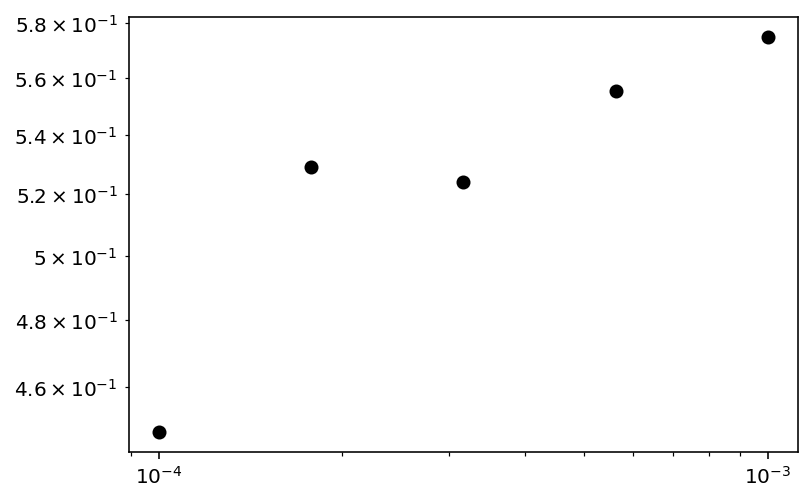

In [21]:
from scipy.ndimage import uniform_filter1d

for s, fs in res.items():
    sigmas = []
    for f in fs:
        traj = gsd.hoomd.open(f, "rb")
        sigma_xy = np.array([snap.log["md/compute/ThermodynamicQuantities/pressure_tensor"][1] for snap in traj])
        sigmas.append(-sigma_xy)
    sigmas = np.mean(sigmas, axis=0)
    xy = np.array([snap.configuration.box[3] for snap in traj])
    # plt.plot(xy, uniform_filter1d(sigmas, 5))
    plt.plot(s, np.mean(sigmas[xy > 0.2]), "ko")
plt.yscale('log')
plt.xscale('log')

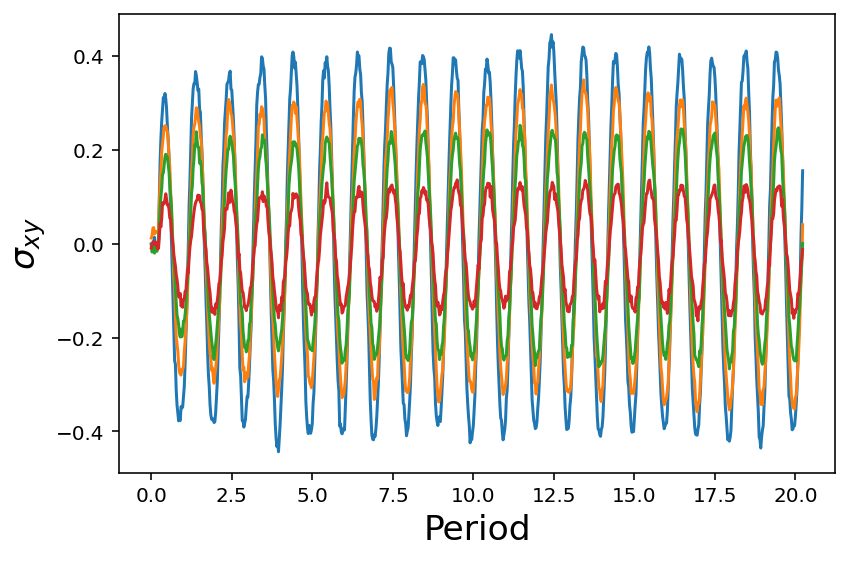

In [8]:
from scipy.ndimage import uniform_filter1d

plt.figure(tight_layout=True)

iter = list(res.items())
iter.reverse()
for s, fs in iter:
    sigmas = []
    for f in fs:
        traj = gsd.hoomd.open(f, "rb")
        sigma_xy = np.array([snap.log["md/compute/ThermodynamicQuantities/pressure_tensor"][1] for snap in traj])
        sigmas.append(-sigma_xy)
    sigmas = np.mean(sigmas, axis=0)
    xy = np.array([snap.configuration.box[3] for snap in traj])

    periods = np.linspace(0, len(xy)/40, len(xy), endpoint=False)
    # plt.plot(xy, uniform_filter1d(sigmas, 5))
    # cond = xy > 0.2
    plt.plot(periods, sigmas)
# plt.yscale('log')
# plt.xscale('log')
plt.ylabel(r"$\sigma_{xy}$", size="xx-large")
plt.xlabel("Period", size="xx-large")
plt.savefig("os-attr_050523_fig1.png")

In [18]:
len(xy)

810

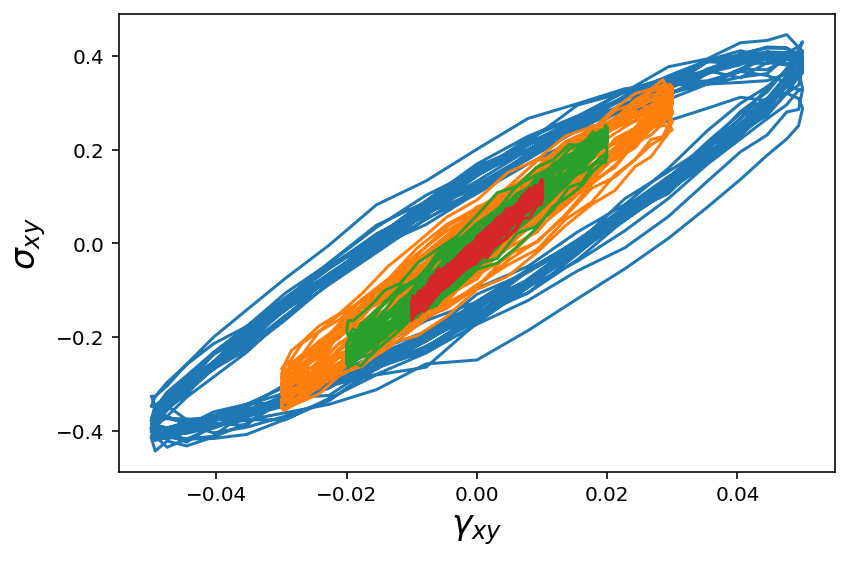

In [6]:
from scipy.ndimage import uniform_filter1d

plt.figure(tight_layout=True)

iter = list(res.items())
iter.reverse()
for s, fs in iter:
    sigmas = []
    for f in fs:
        traj = gsd.hoomd.open(f, "rb")
        sigma_xy = np.array([snap.log["md/compute/ThermodynamicQuantities/pressure_tensor"][1] for snap in traj])
        sigmas.append(-sigma_xy)
    sigmas = np.mean(sigmas, axis=0)
    xy = np.array([snap.configuration.box[3] for snap in traj])
    # plt.plot(xy, uniform_filter1d(sigmas, 5))
    plt.plot(xy, sigmas)
# plt.yscale('log')
# plt.xscale('log')
plt.ylabel(r"$\sigma_{xy}$", size="xx-large")
plt.xlabel(r"$\gamma_{xy}$", size="xx-large")
plt.savefig("os-attr_050523_fig2.png")

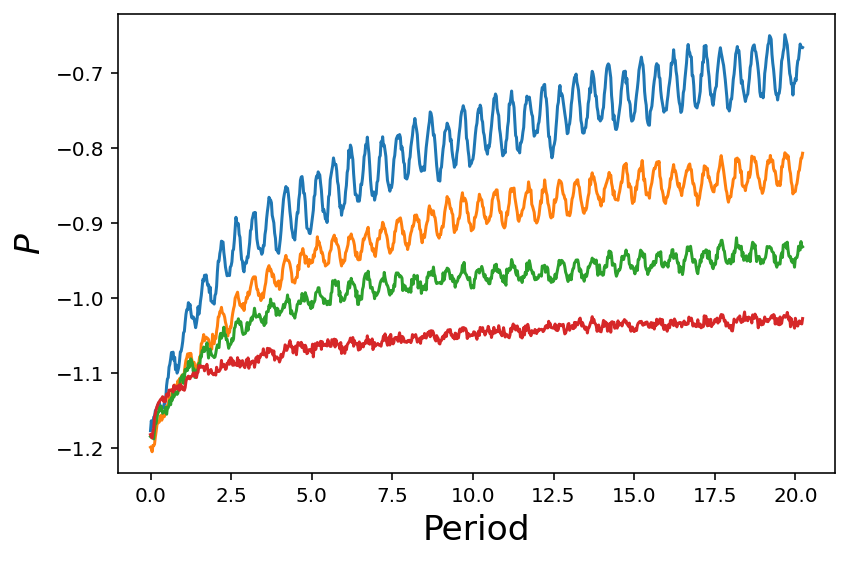

In [9]:
from scipy.ndimage import uniform_filter1d

plt.figure(tight_layout=True)

iter = list(res.items())
iter.reverse()
for s, fs in iter:
    sigmas = []
    for f in fs:
        traj = gsd.hoomd.open(f, "rb")
        sigma_xy = np.array([snap.log["md/compute/ThermodynamicQuantities/pressure"][0] for snap in traj])
        sigmas.append(-sigma_xy)
    sigmas = np.mean(sigmas, axis=0)
    xy = np.array([snap.configuration.box[3] for snap in traj])

    periods = np.linspace(0, len(xy)/40, len(xy), endpoint=False)
    # plt.plot(xy, uniform_filter1d(sigmas, 5))
    # cond = xy > 0.2
    plt.plot(periods, sigmas)
# plt.yscale('log')
# plt.xscale('log')
plt.ylabel(r"$P$", size="xx-large")
plt.xlabel("Period", size="xx-large")
plt.savefig("os-attr_050523_fig3.png")